# Joint Model

In [1]:
import itertools
from functools import partial
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from bayesflow import diagnostics
from bayesflow.simulation import Simulator
from scipy.optimize import minimize
from scipy.special import expit  # sigmoid aka logistic function
from tqdm import tqdm
from inference.base_nlme_model import NlmeBaseAmortizer
from inference.ploting_routines import visualize_pesto_result

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def incidence(t):
    segment_size = 1  # Define the size of each segment
    segment = t // segment_size  # Determine the segment index
    constant_value = np.sin(segment * segment_size * 2 * np.pi / 100) / 100 + 0.02  # Calculate the constant value within the segment
    return constant_value

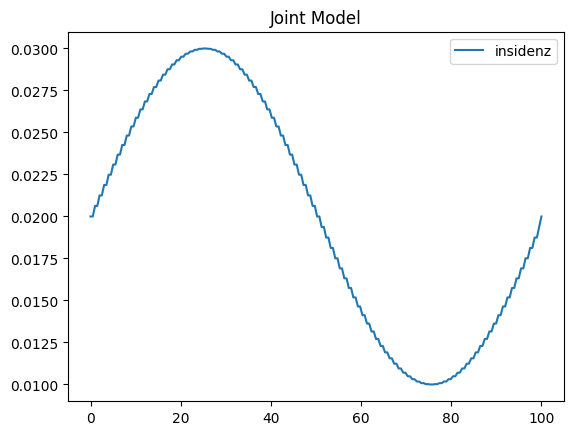

In [3]:
time = np.linspace(0, 100, 200)
plt.plot(time, incidence(time), label='insidenz')
plt.title('Joint Model')
plt.legend()
plt.show()

# Estimation of the hazard function

In [4]:
class linearModel(NlmeBaseAmortizer):
    def __init__(self, name: str = 'myModel'):
        # define names of parameters
        param_names = ['intercept', 'slope', 'error-variance']

        # define prior values (for log-parameters)
        prior_mean = np.array([np.log(2500), -3, -2])
        prior_cov = np.diag([1, 1, 0.1])
        self.prior_type = 'normal'

        super().__init__(name=name,
                         param_names=param_names,
                         prior_mean=prior_mean,
                         prior_cov=prior_cov)

        self.simulator = Simulator(batch_simulator_fun=partial(self.batch_simulator))
        
    # define simulator
    @staticmethod
    def batch_simulator(param_batch: np.ndarray, time: Optional[np.ndarray] = None, 
                        maxtime: int = 100, with_noise: bool = True) -> np.ndarray:
        param_batch = np.exp(param_batch)

        if param_batch.ndim == 1:  # so not (batch_size, params)
            # just a single parameter set
            param_batch = param_batch[np.newaxis, :]

        if time is None:
            n_measurements = np.random.randint(1, 5)
            time = np.random.uniform(0, maxtime, n_measurements)
            time.sort()

        # simulate data
        y = np.zeros((param_batch.shape[0], time.size, 2))
        for p_id, params in enumerate(param_batch):
            # model plus noise
            y[p_id, :, 0] = params[0] * np.exp(-params[1] * time)
            if with_noise:
                y[p_id, :, 0] *= ( 1 + params[2] * np.random.normal(loc=0, scale=1, size=time.size))
            y[p_id, :, 1] = time / maxtime

        # add censoring
        y[:, :, 0] = np.log(np.clip(y[:, :, 0], a_min=0.001, a_max=2500))
        return y
        
    def load_amortizer_configuration(self, model_idx: int = 0, load_best: bool = False) -> str:
        self.n_epochs = 10
        bidirectional_LSTM = [False]
        n_coupling_layers = [2, 3]
        n_dense_layers_in_coupling = [2]
        coupling_design = ['affine']
        summary_network_type = ['sequence']

        combinations = list(itertools.product(bidirectional_LSTM, n_coupling_layers,
                                              n_dense_layers_in_coupling, coupling_design, summary_network_type))

        (self.bidirectional_LSTM,
         self.n_coupling_layers,
         self.n_dense_layers_in_coupling,
         self.coupling_design,
         self.summary_network_type) = combinations[model_idx]

        model_name = f'amortizer-toyModel-{self.prior_type}' \
                     f'-{self.summary_network_type}-summary' \
                     f'-{"Bi-LSTM" if self.bidirectional_LSTM else "LSTM"}' \
                     f'-{self.n_coupling_layers}layers' \
                     f'-{self.n_dense_layers_in_coupling}coupling-{self.coupling_design}' \
                     f'-{self.n_epochs}epochs'
        return model_name
        
    def plot_example(self, params: Optional[np.ndarray] = None) -> None:
        raise NotImplementedError('Not implemented yet.')
        
    def prepare_plotting(self, data: np.ndarray, params: np.ndarray, ax: Optional[plt.Axes] = None) -> plt.Axes:
        raise NotImplementedError('Not implemented yet.')

In [5]:
toy_model = linearModel()

using 2 layers of MultiConv1D, a  LSTM with 256 units and a dense layer with output dimension 10 as summary network
using a 3-layer cINN as inference network with 2 layers of design affine
prior mean: [ 7.82404601 -3.         -2.        ]
prior covariance diagonal: [1.  1.  0.1]


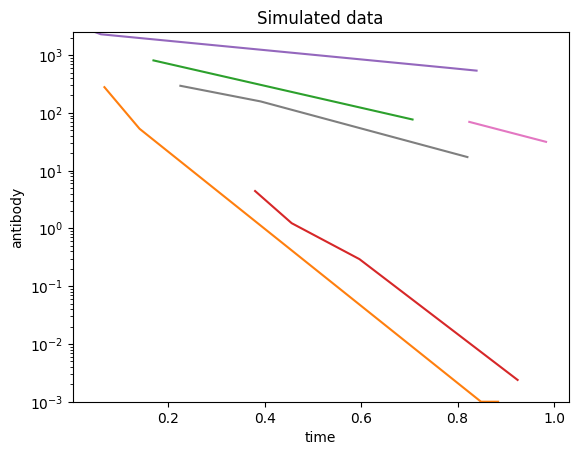

In [6]:
for i in range(10):
    prior_sample = toy_model.prior(1)['prior_draws']
    yt = toy_model.simulator(prior_sample)['sim_data']
    plt.plot(yt[0, :, 1], np.exp(yt[0, :, 0]))
plt.xlabel('time')
plt.ylabel('antibody')
plt.yscale('log')
plt.title('Simulated data')
plt.ylim(0.001, 2500)
plt.show()

In [7]:
trainer = toy_model.build_trainer('../networks/' + toy_model.network_name)

INFO:root:Performing 2 pilot runs with the myModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-toyModel-normal-sequence-summary-LSTM-3layers-2coupling-affine-10epochs/history_104.pkl.
INFO:root:Networks loaded from ../networks/amortizer-toyModel-normal-sequence-summary-LSTM-3layers-2coupling-affine-10epochs/ckpt-104
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  219702    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  306058    
 Network)                                                        
                                                                 
Total params: 525760 (2.01 MB)
Trainable params: 525742 (2.01 MB)
Non-trainable params: 18 (72.00 Byte)
_________________________________________________________________
None


In [8]:
new_sims = toy_model.generate_simulations_from_prior(trainer=trainer, n_samples=2500)
posterior_draws = toy_model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=100)

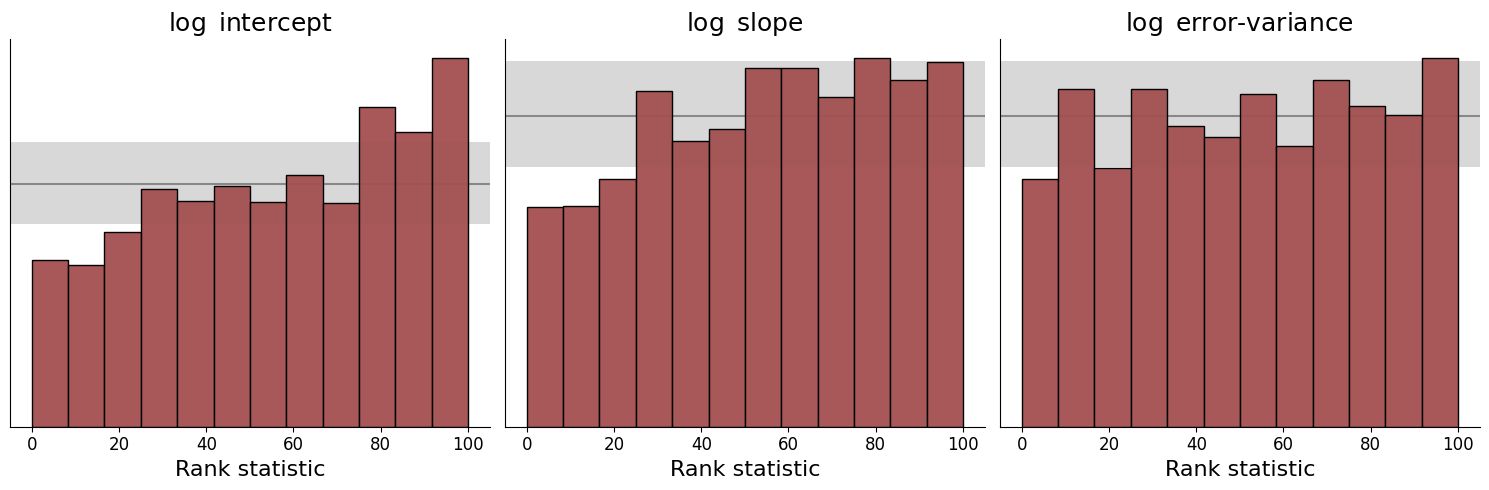

In [9]:
fig_sbc = diagnostics.plot_sbc_histograms(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          param_names=toy_model.log_param_names)

In [10]:
from inference.helper_functions import create_mixed_effect_model_param_names

np.random.seed(42)
toy_samples = toy_model.prior(100)['prior_draws']
toy_samples[:, -2:] = toy_model.prior_mean[-2:]
toy_data = toy_model.simulator(toy_samples)['sim_data']

mixed_effect_params_names = create_mixed_effect_model_param_names(toy_model.param_names, 
                                                                  cov_type='diag')
joint_model_names = mixed_effect_params_names + ['log_baseline_hazard', 'log_influence_antibody']

In [11]:
fixed_indices = np.array([4,5])
fixed_values = np.array([-np.log(0.001), -np.log(0.001)])

In [12]:
# generate data
np.random.seed(42)

linear_pars = 2200, 0.02
hazard_pars = 9, 0.3
random_variance = 0.1
error_variance = 0.1

In [13]:
def generate_patient_data(max_time: int = 100):
    re = np.exp(np.random.normal(0, random_variance))
    log_params = np.log(np.array([linear_pars[0]*re, linear_pars[1], error_variance]))
    
    vaccine_date = np.random.randint(0, max_time // 2)
    # get hazard function and compute cdf: F = 1 - S, S = exp(-integral h(t) )
    def h_func_temp(t):  # t is a 1d-vector, real time, observations start at vaccine_date until infection_event
        sim = toy_model.batch_simulator(
                    param_batch=log_params,
                    time=np.array([t - vaccine_date]), 
                    with_noise=False)[0, :, 0]
        return hazard_pars[0] * incidence(t) * (1 - expit(hazard_pars[1] * sim))
    # sample uniform, solve rand = F(t) to get infection event
    rand = np.random.uniform(0, 1)
    # using gaussian quadrature, t is now 
    cdf_hazard = lambda t_shift: (1 - np.exp(-integrate.fixed_quad(h_func_temp, 
                                                                   vaccine_date, 
                                                                   vaccine_date+t_shift[0],
                                                                   n=5)[0]) - rand)**2  # t is a 1d-vector
    # integrand, err = integrate.fixed_quad(h_func, vaccine_date, 100, n=5)
    #sol = minimize(cdf_hazard, x0=np.array([0]), method='TNC', bounds=((0, 100-vaccine_date),))
    #infection_event = int(sol.x[0]) + vaccine_date
    
    # find minimum of cdf_hazard since incidence is piecewise constant
    time_min = np.linspace(0, max_time-vaccine_date, max_time-vaccine_date)
    sol = np.argmin([cdf_hazard(np.array([t])) for t in time_min])
    infection_event = vaccine_date + int(time_min[sol])

    # check if event is censored    
    if infection_event == max_time:
        event_is_censored = True
    else:
        event_is_censored = False
            
    # get measurements of antibody model in time frame
    if infection_event == vaccine_date:
        time = np.array([vaccine_date])
    else:
        time = np.linspace(vaccine_date, infection_event, infection_event-vaccine_date)
    obs_data = toy_model.batch_simulator(log_params, time=time-vaccine_date,
                                         with_noise=True)[0]  # always start at 0

    # maximum of 4 measurements
    m_index = np.random.choice(np.arange(len(time)), size=min(4, len(time)), replace=False)
    m_index.sort()
    return log_params, obs_data[m_index], time[m_index], infection_event, event_is_censored, vaccine_date

In [14]:
def generate_data(n_individuals: int = 500):
    joint_model_obs = []
    true_params = []
    while True:
        if len(joint_model_obs) == n_individuals:
            break
        log_params_i, obs_data_i, time_i, infection_event_i, event_i_is_censored, vaccine_date_i = generate_patient_data()
        if obs_data_i.shape[0] == 0:
            print(event_i_is_censored)
            continue
        joint_model_obs_i = {
        'obs_data': obs_data_i,
        'time': time_i,
        'infection_event': infection_event_i,
        'event_is_censored': event_i_is_censored,
        'vaccine_date': vaccine_date_i
        }
        true_params_i = {
            'log_params': log_params_i,
            'hazard_pars': hazard_pars
        }
        joint_model_obs.append(joint_model_obs_i)
        true_params.append(true_params_i)
    return joint_model_obs, true_params

np.random.seed(3)
joint_model_obs, true_params = generate_data()
print('individuals', len(joint_model_obs))
print('infected', np.sum([not x['event_is_censored'] for x in joint_model_obs if not x['event_is_censored']]))

individuals 500
infected 338


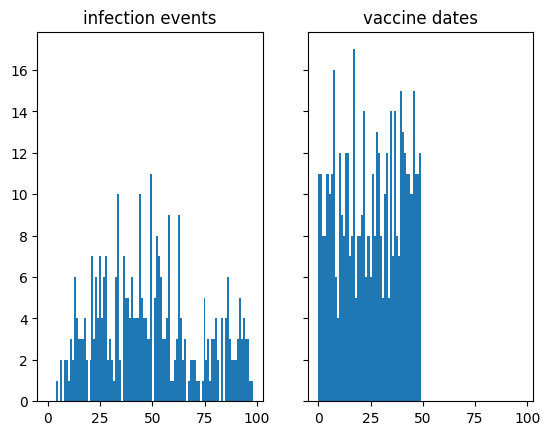

In [15]:
fix, ax = plt.subplots(1, 2, sharex=True, sharey=True)
# plot histogram of infection events
ax[0].hist([x['infection_event'] for x in joint_model_obs if not x['event_is_censored']], bins=100)
ax[0].set_title('infection events')

# plot histogram of vaccine dates
ax[1].hist([x['vaccine_date'] for x in joint_model_obs], bins=50)
ax[1].set_title('vaccine dates')
plt.show()

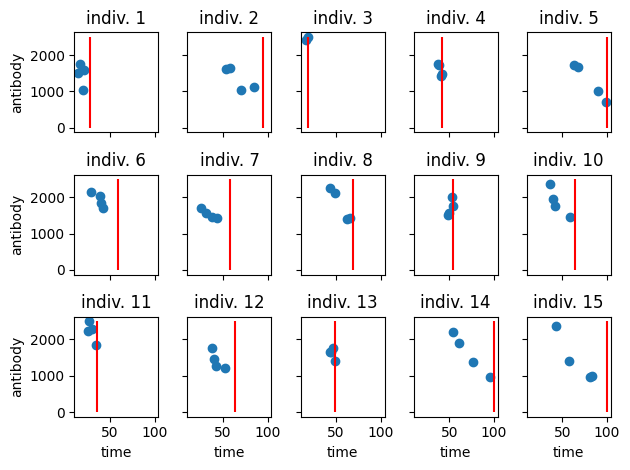

In [16]:
# pick 15 random individuals and plot them
np.random.seed(42)
index_list = np.random.choice(np.arange(len(joint_model_obs)), 15, replace=False)
index_list.sort()
joint_model_obs_rand = [x for i, x in enumerate(joint_model_obs) if i in index_list]

fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, tight_layout=True)
for i in range(len(joint_model_obs_rand)):
    ax[i//5, i%5].scatter(joint_model_obs_rand[i]['time'], np.exp(joint_model_obs_rand[i]['obs_data'][:, 0]))
    ax[i//5, i%5].vlines(joint_model_obs_rand[i]['infection_event'], ymin=0, ymax=2500, color='r')
    ax[i//5, i%5].set_title(f'indiv. {i+1}')
ax[0, 0].set_ylabel('antibody')
ax[1, 0].set_ylabel('antibody')
ax[2, 0].set_ylabel('antibody')
ax[-1, 0].set_xlabel('time')
ax[-1, 1].set_xlabel('time')
ax[-1, 2].set_xlabel('time')
ax[-1, 3].set_xlabel('time')
ax[-1, 4].set_xlabel('time')
plt.show()

In [17]:
def compute_hazard(param_samples: np.ndarray, joint_params: np.ndarray, 
                   joint_model_dict: list[dict], batch_simulator: callable) -> np.ndarray:
    """computes the log hazard function for each individual and sample"""
    n_sim, n_samples, _ = param_samples.shape
    res = np.zeros((n_sim, n_samples))
    
    for ns in range(n_sim):
        infection_event_time_i = joint_model_dict[ns]['infection_event']
        event_i_is_censored = joint_model_dict[ns]['event_is_censored']
        vaccine_date_i = joint_model_dict[ns]['vaccine_date']
        
        for ps in range(n_samples):
            def h_func_temp(t):
                sim = batch_simulator(
                    param_batch=param_samples[ns, ps],
                    time=np.array([t - vaccine_date_i]), 
                    with_noise=False)[0, :, 0]
                return np.exp(joint_params[0]) * incidence(t) * (1 - expit(np.exp(joint_params[1]) * sim))
            # using fixed gaussian quadrature
            integrand, err = integrate.fixed_quad(h_func_temp, vaccine_date_i, infection_event_time_i, n=5)
            # integrate.quad would be a general purpose integrator, but is slower

            # s = np.exp(-integrand)
            log_s = -integrand
            
            if event_i_is_censored:
                res[ns, ps] = log_s
            else:
                res[ns, ps] = log_s + np.log(h_func_temp(infection_event_time_i))
    return res

compute_hazard_helper = partial(compute_hazard, 
                                joint_model_dict=joint_model_obs, batch_simulator=toy_model.batch_simulator)

In [18]:
joint_model_bounds = np.array([[np.log(0.001), np.log(30)], 
                               [np.log(0.001), 0]])

In [33]:
from inference.inference_functions import run_population_optimization

result_optimization, obj_fun_amortized = run_population_optimization(
    individual_model=toy_model,
    data=[item['obs_data'] for item in joint_model_obs],
    param_names=joint_model_names,
    cov_type='diag',
    n_multi_starts=10,
    n_samples_opt=50,
    covariates_bounds=None,
    covariates=None,
    n_covariates_params=0,
    covariate_mapping=None,
    n_joint_params=len(hazard_pars),
    joint_model_bounds=joint_model_bounds,
    joint_model_term=compute_hazard_helper,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    file_name=f'../output/joint_model_test.hdf5',
    verbose=True,
    trace_record=True,
    pesto_multi_processes=10,
    result=None  #result_optimization
)

Multi-start optimization:   0%|          | 0/1 [00:00<?, ?it/s]

                               free   lb_full    ub_full
pop-intercept                  True  4.824046  10.824046
pop-slope                      True -6.000000   0.000000
pop-error-variance             True -2.948683  -1.051317
$-\log$ (var-intercept)        True -1.327625   6.907755
$-\log$ (var-slope)           False -1.327625   6.907755
$-\log$ (var-error-variance)  False -1.327625   6.907755
log_baseline_hazard            True -6.907755   3.401197
log_influence_antibody         True -6.907755   0.000000
                              fixed value
$-\log$ (var-slope)              6.907755
$-\log$ (var-error-variance)     6.907755



Multi-start optimization: 100%|██████████| 1/1 [18:24<00:00, 1104.99s/it]


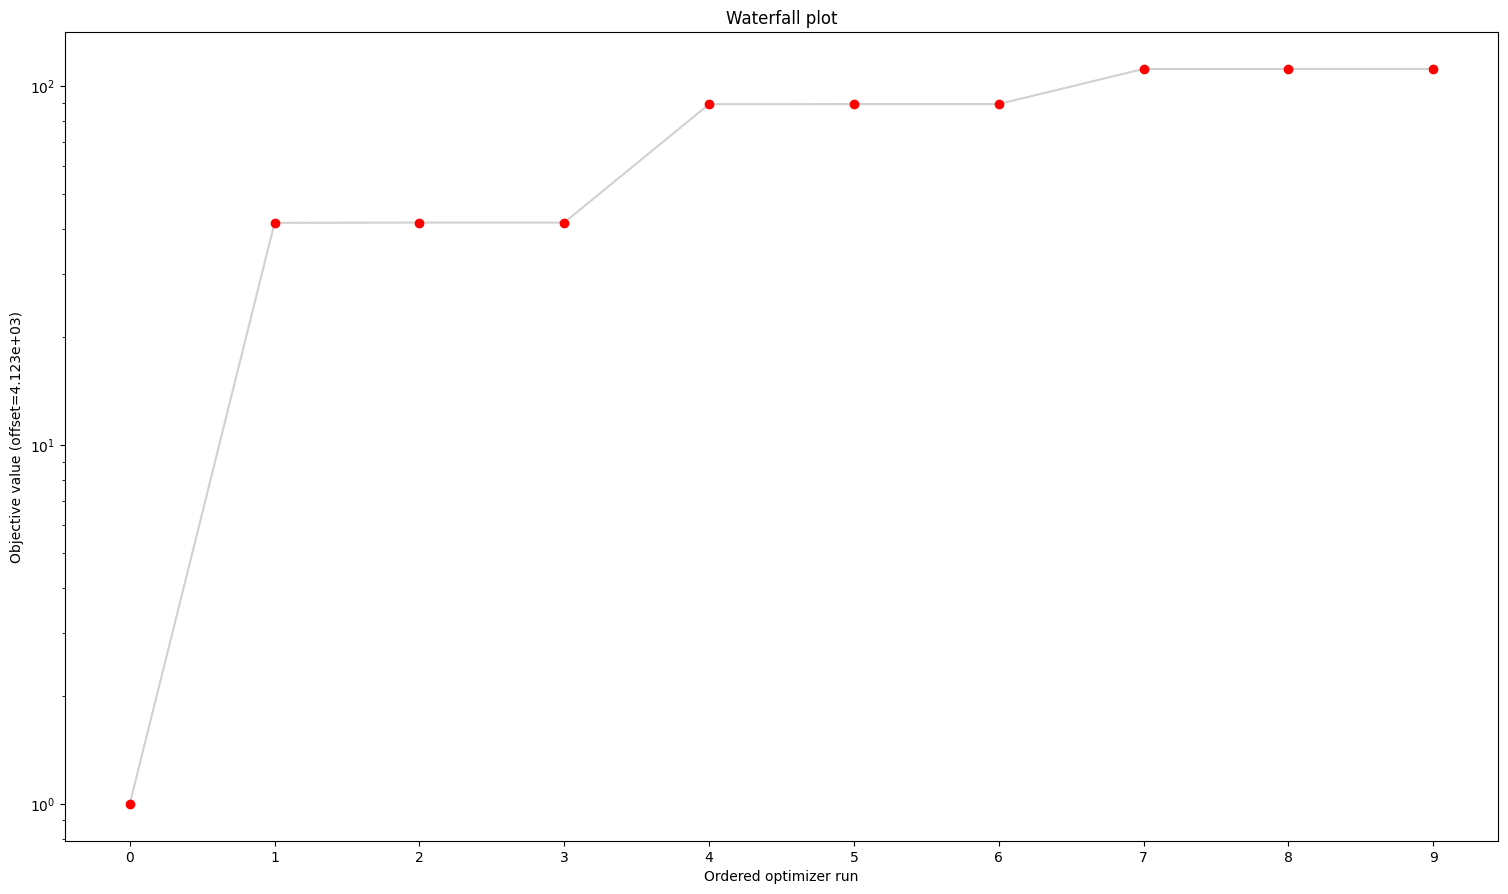

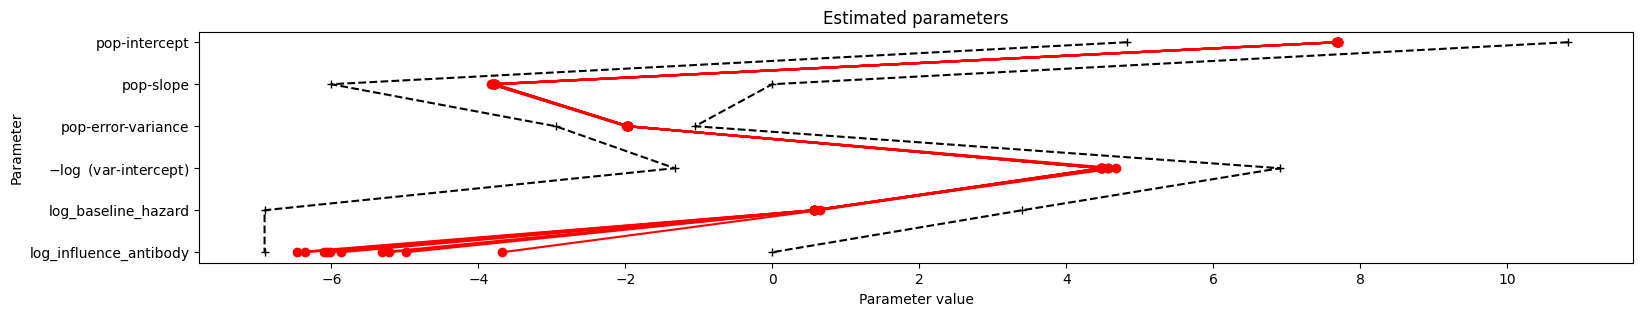

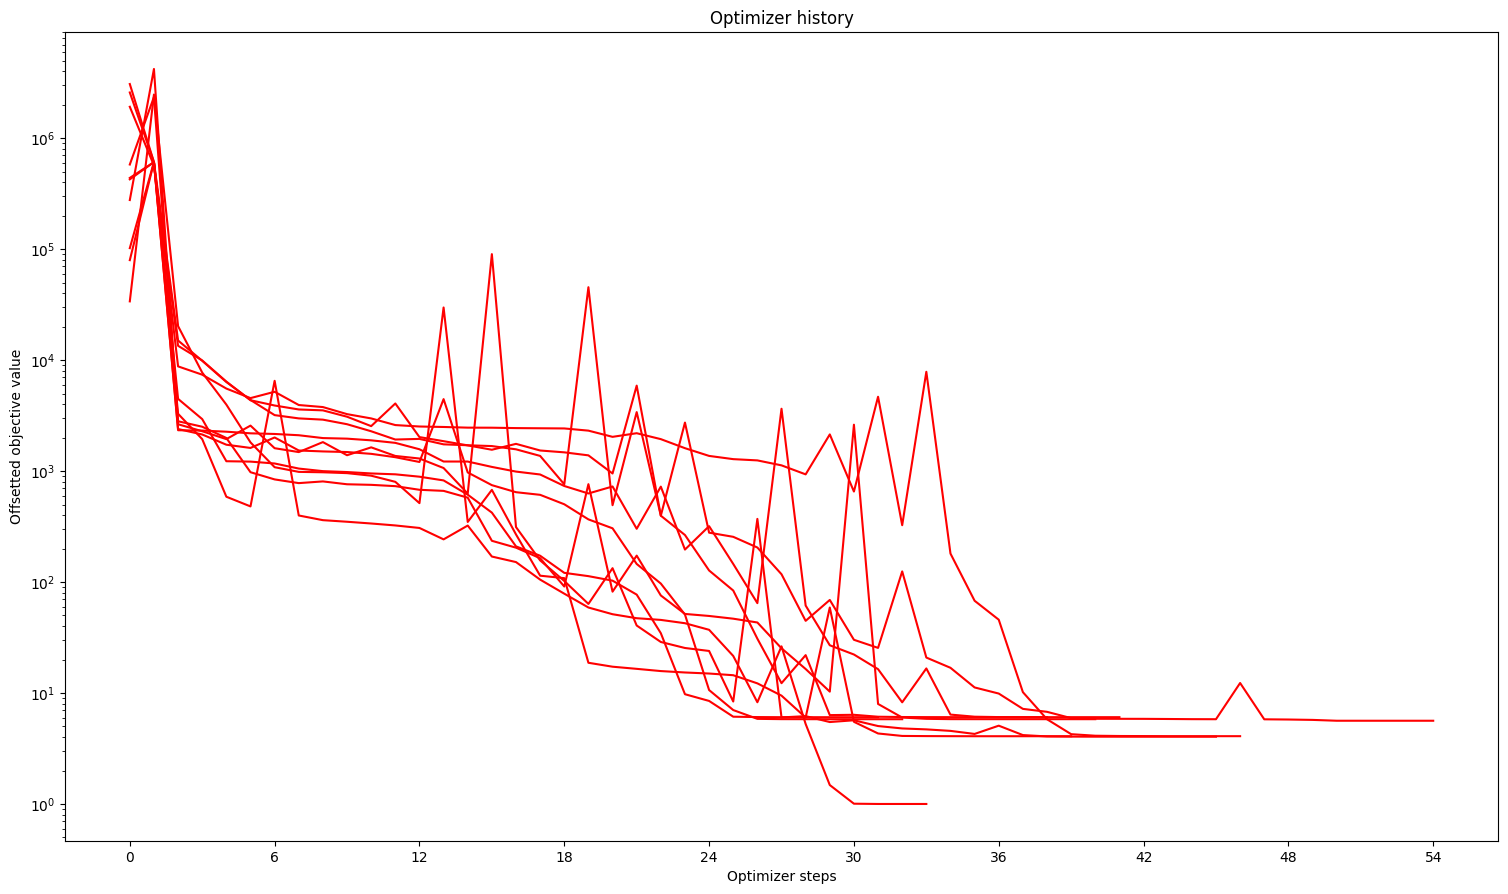

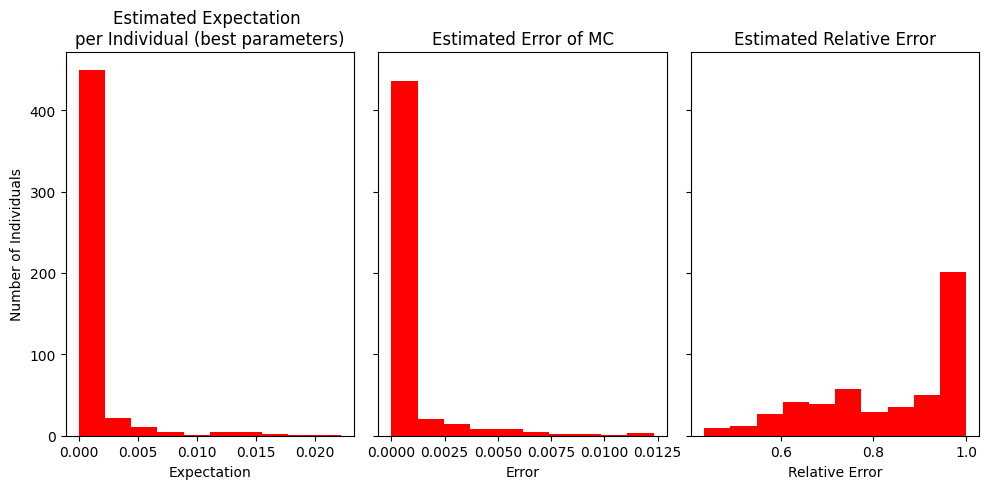

In [34]:
visualize_pesto_result(result_optimization, use_batch_coloring=True, obj_fun_amortized=obj_fun_amortized)

In [35]:
result_index = -1
estimate = np.concatenate((result_optimization.optimize_result.x[result_index][:3], 
                           np.exp(-result_optimization.optimize_result.x[result_index][3:6]), 
                           np.exp(result_optimization.optimize_result.x[result_index][6:])))

full_params = np.stack([param['log_params'] for param in true_params])
test_val = np.concatenate((np.mean(full_params, axis=0), np.var(full_params, axis=0), hazard_pars))
test_val[np.abs(test_val) < 1e-8] = 0.001

pd.DataFrame(estimate.round(5), index=joint_model_names, columns=['estimate'])

,estimate
pop-intercept,7.70120
pop-slope,-3.77488
pop-error-variance,-1.95715
var-intercept,0.01142
var-slope,0.00100
var-error-variance,0.00100
log_baseline_hazard,1.75800
log_influence_antibody,0.00242


In [40]:
pd.DataFrame(((estimate-test_val)**2/(test_val**2)).round(5), index=joint_model_names, columns=['rel error squared'])

,rel error squared
pop-intercept,0.00000
pop-slope,0.00123
pop-error-variance,0.02251
var-intercept,0.03793
var-slope,0.00000
var-error-variance,0.00000
log_baseline_hazard,0.64749
log_influence_antibody,0.98390


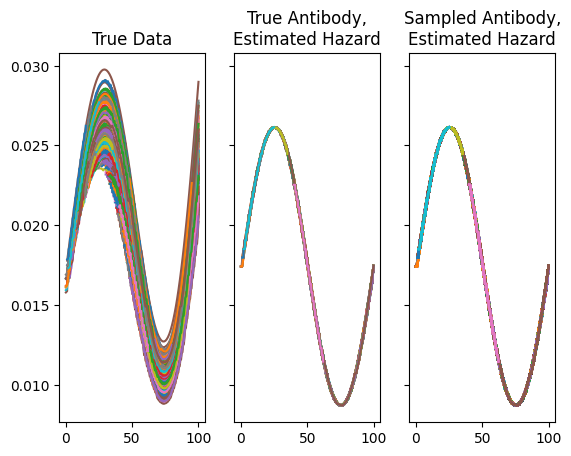

In [55]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
for i in range(len(joint_model_obs)):    
    def h_func(t):
        sim = toy_model.batch_simulator(
                        param_batch=true_params[i]['log_params'],
                        time=np.array([t - joint_model_obs[i]['vaccine_date']]), 
                        with_noise=False)[0, :, 0]
        return true_params[i]['hazard_pars'][0] * incidence(t) * (1 - expit(true_params[i]['hazard_pars'][1] * sim))
    time = np.linspace(joint_model_obs[i]['vaccine_date'], joint_model_obs[i]['infection_event'], 100)
    real_hazard = [h_func(t) for t in time]
    ax[0].plot(time, real_hazard, label=f'individual {i}')
ax[0].set_title('True Data')  
h, l = ax[0].get_legend_handles_labels()


for i in range(len(joint_model_obs)):
    color = h[i].get_color()  # color of individual
    def h_func(t):
        sim = toy_model.batch_simulator(
                        param_batch=true_params[i]['log_params'],
                        time=np.array([t - joint_model_obs[i]['vaccine_date']]), 
                        with_noise=False)[0, :, 0]
        return estimate[-2] * incidence(t) * (1 - expit(estimate[-1] * sim))
    time = np.linspace(joint_model_obs[i]['vaccine_date'], joint_model_obs[i]['infection_event'], 100)
    hazard = [h_func(t) for t in time]
    ax[1].plot(time, hazard, color=color)
ax[1].set_title('True Antibody,\nEstimated Hazard')

for i in range(len(joint_model_obs)):
    color = h[i].get_color()  # color of individual

    sampled_params = np.random.multivariate_normal(mean=estimate[:3], cov=np.diag(estimate[3:6]), size=10)
    for sp in sampled_params:
        def h_func(t):
            sim = toy_model.batch_simulator(
                        param_batch=sp,
                        time=np.array([t - joint_model_obs[i]['vaccine_date']]), 
                        with_noise=False)[0, :, 0]
            return estimate[-2] * incidence(t) * (1 - expit(estimate[-1] * sim))
        
        time = np.linspace(joint_model_obs[i]['vaccine_date'], joint_model_obs[i]['infection_event'], 100)
        hazard = [h_func(t) for t in time]
        ax[2].plot(time, hazard, color=color) 
ax[2].set_title('Sampled Antibody,\nEstimated Hazard')
plt.show()

In [42]:
# only fitting the hazard function
def neg_log_likelihood_hazard(current_hazard_pars: np.ndarray) -> float:
    sol = np.zeros(len(joint_model_obs))
    
    for ns in range(len(joint_model_obs)):
        infection_event_time_i = joint_model_obs[ns]['infection_event']
        event_i_is_censored = joint_model_obs[ns]['event_is_censored']
        vaccine_date_i = joint_model_obs[ns]['vaccine_date']
        
        def h_func_temp(t):
            sim = toy_model.batch_simulator(
                    param_batch=true_params[ns]['log_params'],
                    time=np.array([t - vaccine_date_i]), 
                    with_noise=False)[0, :, 0]
            return np.exp(current_hazard_pars[0]) * incidence(t) * (1 - expit(np.exp(current_hazard_pars[1]) * sim))
        
        if not event_i_is_censored:
            temp = np.log(h_func_temp(infection_event_time_i))
        else:
            temp = 0
        
        integrand, err = integrate.fixed_quad(h_func_temp, vaccine_date_i, infection_event_time_i, n=5)
        sol[ns] = temp - integrand
    return -np.sum(sol)

In [43]:
neg_log_likelihood_hazard(np.log(hazard_pars))

1811.869716562396

In [44]:
sol = minimize(neg_log_likelihood_hazard, x0=np.log(hazard_pars), method='L-BFGS-B', bounds=joint_model_bounds)
sol

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1811.0717650913384
        x: [ 2.903e+00 -9.171e-01]
      nit: 10
      jac: [-6.912e-03  1.824e-02]
     nfev: 54
     njev: 18
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [45]:
neg_log_likelihood_hazard(np.log(hazard_pars)), neg_log_likelihood_hazard(sol.x)

(1811.869716562396, 1811.0717650913384)

In [46]:
hazard_pars, np.exp(sol.x), estimate[-2:]

((9, 0.3), array([18.22172612,  0.3996762 ]), array([1.75799565, 0.00242409]))

In [47]:
sample_mean = np.mean([true_params[i]['log_params'] for i in range(len(true_params))], axis=0)
def h_func(t):
    sim = toy_model.batch_simulator(
            param_batch=sample_mean,
            time=np.array([t]), 
            with_noise=False)[0, :, 0]
    return hazard_pars[0] * incidence(t) * (1 - expit(hazard_pars[1] * sim))
        
S = [np.exp(-integrate.fixed_quad(h_func, 0, t, n=5)[0]) for t in range(200)]

def h_func_estimated(t):
    sim = toy_model.batch_simulator(
            param_batch=sample_mean,
            time=np.array([t]), 
            with_noise=False)[0, :, 0]
    return np.exp(sol.x)[0] * incidence(t) * (1 - expit(np.exp(sol.x)[1] * sim))
        
S_estimated = [np.exp(-integrate.fixed_quad(h_func_estimated, 0, t, n=5)[0]) for t in range(200)]

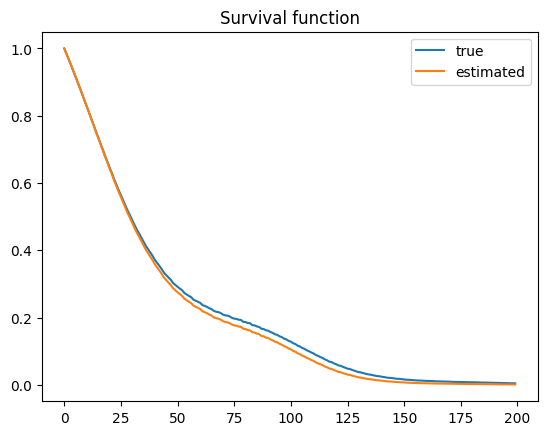

In [48]:
plt.plot(range(200), S, label='true')
plt.plot(range(200), S_estimated, label='estimated')
#plt.fill_between(range(100), np.min(S_CI, axis=0), np.max(S_CI, axis=0))
plt.legend()
plt.title('Survival function')
plt.show()

# testing fit of hazard function

In [49]:
np.random.seed(42)
mcmc_results = np.zeros((100, 2))
for run_i in tqdm(range(mcmc_results.shape[0])):
    joint_model_obs, true_params = generate_data(n_individuals=500)
    
    def neg_log_likelihood_hazard(current_hazard_pars: np.ndarray) -> float:
        sol = np.zeros(len(joint_model_obs))
        
        for ns in range(len(joint_model_obs)):
            infection_event_time_i = joint_model_obs[ns]['infection_event']
            event_i_is_censored = joint_model_obs[ns]['event_is_censored']
            vaccine_date_i = joint_model_obs[ns]['vaccine_date']
            
            def h_func_temp(t):
                sim = toy_model.batch_simulator(
                        param_batch=true_params[ns]['log_params'],
                        time=np.array([t - vaccine_date_i]), 
                        with_noise=False)[0, :, 0]
                return np.exp(current_hazard_pars[0]) * incidence(t) * (1 - expit(np.exp(current_hazard_pars[1]) * sim))
            
            if not event_i_is_censored:
                temp = np.log(h_func_temp(infection_event_time_i))
            else:
                temp = 0
            
            integrand, err = integrate.fixed_quad(h_func_temp, vaccine_date_i, infection_event_time_i, n=5)
            sol[ns] = temp - integrand
        return -np.sum(sol)
    
    sol = minimize(neg_log_likelihood_hazard, x0=np.log(hazard_pars), method='L-BFGS-B', bounds=joint_model_bounds)
    mcmc_results[run_i] = np.exp(sol.x)

  2%|▏         | 2/100 [00:06<05:03,  3.10s/it]


KeyboardInterrupt: 

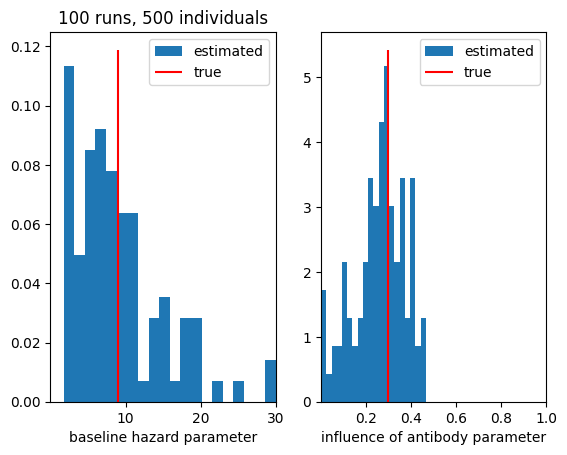

In [32]:
fig, ax = plt.subplots(1, 2)

ax[0].hist(mcmc_results[:, 0], bins=20, label='estimated', density=True)
ax[0].vlines(hazard_pars[0], ymin=0, ymax=ax[0].get_ylim()[1], color='r', label='true')
ax[0].set_xlabel('baseline hazard parameter')
ax[0].set_xlim(np.exp(joint_model_bounds[0, :]))
ax[0].legend()

ax[1].hist(mcmc_results[:, 1], bins=20, label='estimated', density=True)
ax[1].vlines(hazard_pars[1], ymin=0, ymax=ax[1].get_ylim()[1], color='r', label='true')
ax[1].set_xlabel('influence of antibody parameter')
ax[1].set_xlim(np.exp(joint_model_bounds[1, :]))
ax[1].legend()
ax[0].set_title(f'{mcmc_results.shape[0]} runs, {len(joint_model_obs)} individuals')
plt.show()